In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (10631, 0.2526)  |  explosion: (10106, 0.2402)  |  noise: (21343, 0.5072)  
Val ds:
earthquake: (242, 0.0371)  |  explosion: (3125, 0.4788)  |  noise: (3160, 0.4841)  
Test ds:
earthquake: (184, 0.0423)  |  explosion: (2062, 0.4739)  |  noise: (2105, 0.4838)  


In [3]:
model_type = "Meier_CNN"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "normalize"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = True)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()

Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 17.473477363586426 seconds. Total datapoints fitted: 42080.
Average time per datapoint: 0.0004152442339255329


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 3.325265884399414 seconds. Total datapoints fitted: 6527.
Average time per datapoint: 0.0005094631353453982


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 2.1843297481536865 seconds. Total datapoints fitted: 4351.
Average time per datapoint: 0.0005020293606420792


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validation set, timeAug: [--------------------------------------->] 100 %

Stage one loading test set, timeAug: [--------------------------------------->] 100 %

Fit process of normalizer skipped as unecessary


Stage two loading 

['20210507-172347']
[   {'model_type': 'Meier_CNN'},
    {   'batch_size': 48,
        'epochs': 40,
        'use_averagepool': True,
        'use_batchnorm': True,
        'use_maxpool': False}]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6000, 32)          1568      
_________________________________________________________________
average_pooling1d (AveragePo (None, 3000, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3000, 32)          128       
_________________________________________________________________
activation (Activation)      (None, 3000, 32)          0         
_______________________________________________________________

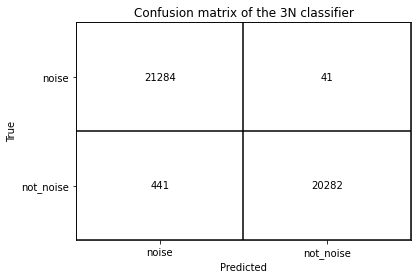

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[21284,    41],
       [  441, 20282]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.98      1.00      0.99     21325
   not_noise       1.00      0.98      0.99     20723

    accuracy                           0.99     42048
   macro avg       0.99      0.99      0.99     42048
weighted avg       0.99      0.99      0.99     42048

Unsaved val eval:
3066 67 93 3254
['noise', 'not_noise']
3N


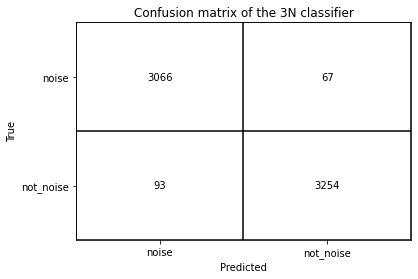

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3066,   67],
       [  93, 3254]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.97      0.98      0.97      3133
   not_noise       0.98      0.97      0.98      3347

    accuracy                           0.98      6480
   macro avg       0.98      0.98      0.98      6480
weighted avg       0.98      0.98      0.98      6480

Unsaved test eval:
2030 56 76 2158
['noise', 'not_noise']
3N


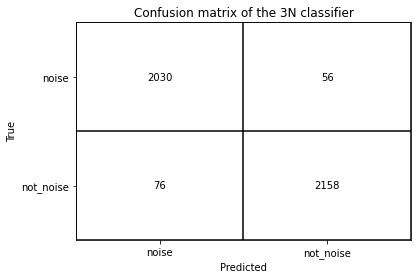

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2030,   56],
       [  76, 2158]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.96      0.97      0.97      2086
   not_noise       0.97      0.97      0.97      2234

    accuracy                           0.97      4320
   macro avg       0.97      0.97      0.97      4320
weighted avg       0.97      0.97      0.97      4320



In [5]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = False

beta = 1

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModelRam(noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, 
                              start_from_scratch = start_from_scratch, beta = beta)
"""
# InceptionTime params
params = {    
    "batch_size" : 512,
    "epochs" : 50,
    "learning_rate" : 0.01,
    "optimizer" : "rmsprop",
    "use_residuals" : True,
    "use_bottleneck" : False,
    "num_modules" : 1,
    "filter_size" : 40,
    "bottleneck_size" : 26,
    "num_filters" : 32,
    "residual_activation" : "tanh",
    "module_activation" : "sigmoid",
    "module_output_activation" : "sigmoid",
    "output_layer_activation": "sigmoid",
    "reg_residual": True,
    "reg_module" : False,
    "l1_r" : 0,
    "l2_r" : 0.1
}
"""
### CNN grow double params
params = {
        "epochs" : 40,
        "batch_size" : 48,
        "use_maxpool" : False,
        "use_averagepool" : True,
        "use_batchnorm" : True
    }
model = modelTrain.run(x_train, y_train, x_val, y_val, x_test, y_test, 16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = True, **params)

3068 65 93 3254


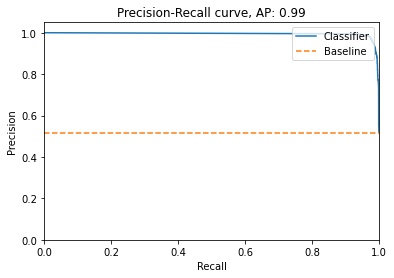

['noise', 'not_noise']
3N


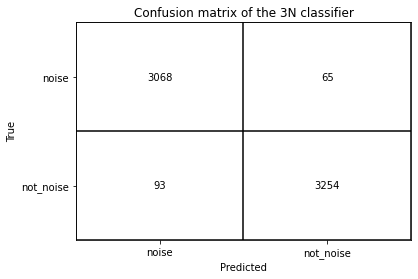

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3068,   65],
       [  93, 3254]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.97      0.98      0.97      3133
   not_noise       0.98      0.97      0.98      3347

    accuracy                           0.98      6480
   macro avg       0.98      0.98      0.98      6480
weighted avg       0.98      0.98      0.98      6480



In [6]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [7]:
accuracy, precision, recall, fscore

(0.97561728395061731, 0.98041599999999995, 0.97221400000000002, 0.976298)

In [9]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/CNN'
model_name = 'CNN_Meier_3E_final'
model_path = f'{save_dir}/{model_name}'

model.save(model_path)
#model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: /media/tord/T7/Thesis_ssd/SavedModels/CNN/CNN_Meier_3E_final/assets


In [23]:
predictions = helper.predict_RamGenerator(model, x_val, y_val, params["batch_size"], True, noiseAug, loadData.label_dict, 3)[:,1]
predictions = np.reshape(predictions, (predictions.shape[0], 1))
rounded_predictions = np.rint(predictions)
y = y_val[:,1]

In [22]:
predictions, y_val

(array([[  1.52732780e-14],
        [  1.69548327e-18],
        [  9.86172336e-17],
        ..., 
        [  1.00000000e+00],
        [  2.19027522e-11],
        [  1.00000000e+00]], dtype=float32),
 array([[1, 0],
        [1, 0],
        [1, 0],
        ..., 
        [1, 0],
        [0, 1],
        [0, 1]], dtype=int8))

In [20]:
def get_false_negative_indexes(rounded_predictions, y_test):
    false_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 0:
            false_negative_indexes.append(i)
    return false_negative_indexes

def get_false_positive_indexes(rounded_predictions, y_test):
    false_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 1:
            false_positive_indexes.append(i)
    return false_positive_indexes

def get_true_positive_indexes(rouneded_predictions, y_test):
    true_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 1:
            true_positive_indexes.append(i)
    return true_positive_indexes

def get_true_negative_indexes(rouneded_predictions, y_test):
    true_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 0:
            true_negative_indexes.append(i)
    return true_negative_indexes

In [24]:
false_negatives_indexes = get_false_negative_indexes(rounded_predictions, y)
false_positives_indexes = get_false_positive_indexes(rounded_predictions, y)
true_negative_indexes = get_true_negative_indexes(rounded_predictions, y)
true_positive_indexes = get_true_positive_indexes(rounded_predictions, y)


# True Positives

In [25]:
import pprint
i = 0
pp = pprint.PrettyPrinter(indent = 4)

Predicted label: [ 1.], Correct: [0 1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


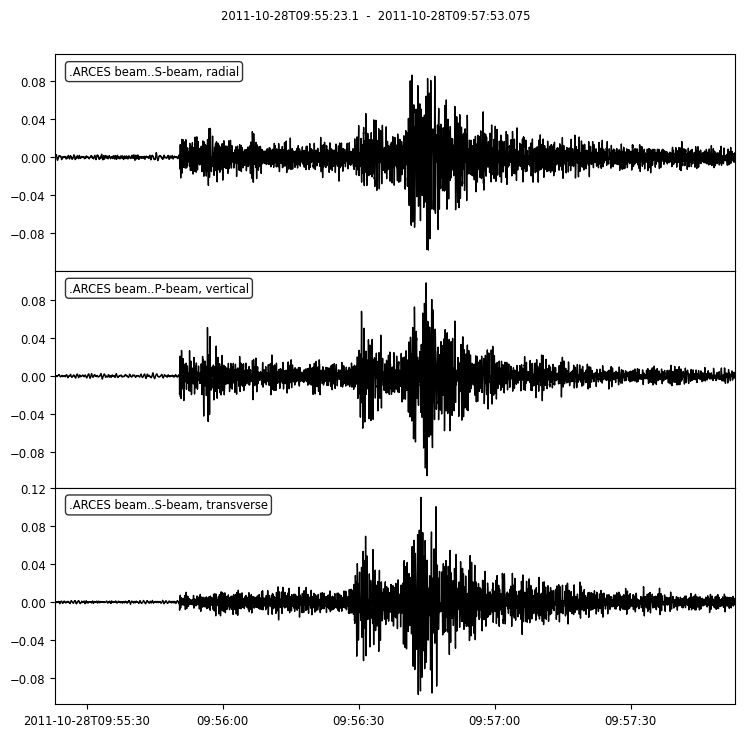

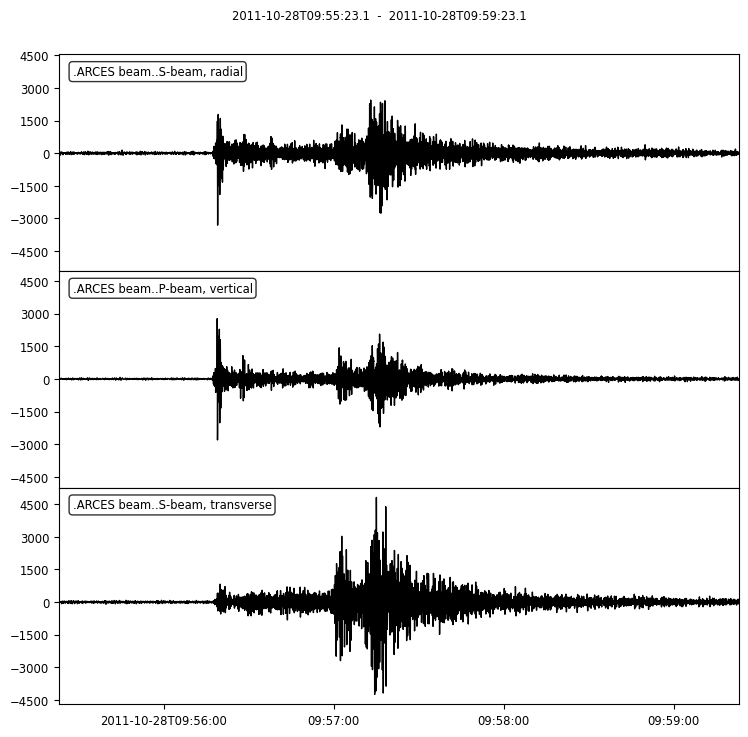

{   'analyst_pick_time': None,
    'az_to_arces': 305.73578325569537,
    'baz_to_arces': 117.87447329641759,
    'dist_to_arces': 404.8733583289168,
    'est_arrivaltime_arces': '2011-10-28 09:56:23.089000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.007340566967080022,
    'magnitude_sqrtdist_ratio': 0.147702962144169,
    'magnitudes': [   {   'mag': 2.972,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/baab84a4-dd4d-46ec-8602-3bc953512aa1',
                          'resource_id': 'smi:local/d5a19fae-9ea2-4a34-953c-f591ce8a92fe'},
                      {   'mag': 2.61,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/baab84a4-dd4d-46ec-8602-3bc953512aa1',
                          'resource_id': 'smi:local/2ca78850-eb9d-4cb6-b7ac-09205c2b7d10'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 25.291736,
              

In [26]:
index = true_positive_indexes[i]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
i += 1

# False Positives

In [27]:
j = 0

Predicted label: [ 1.], Correct: [1 0]
Transformed
6


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


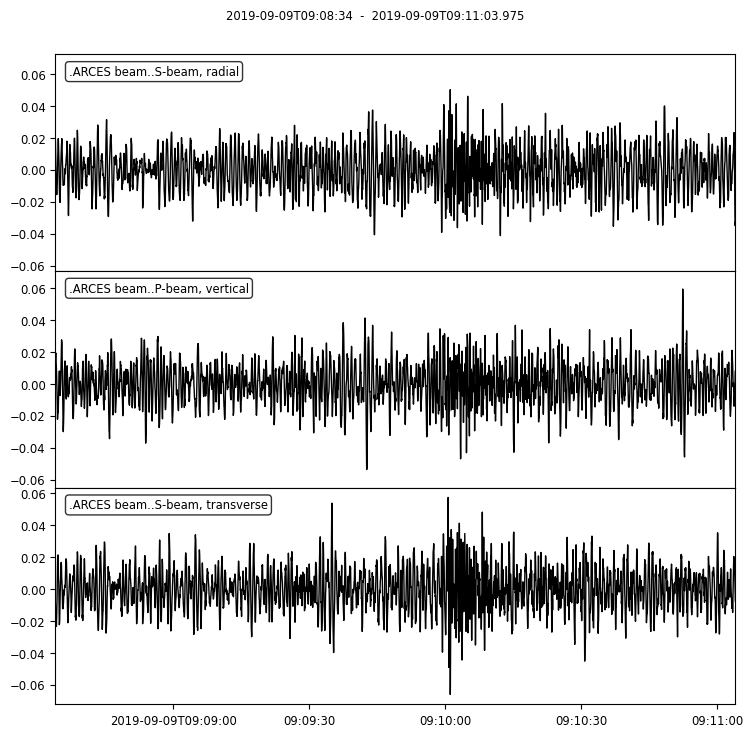

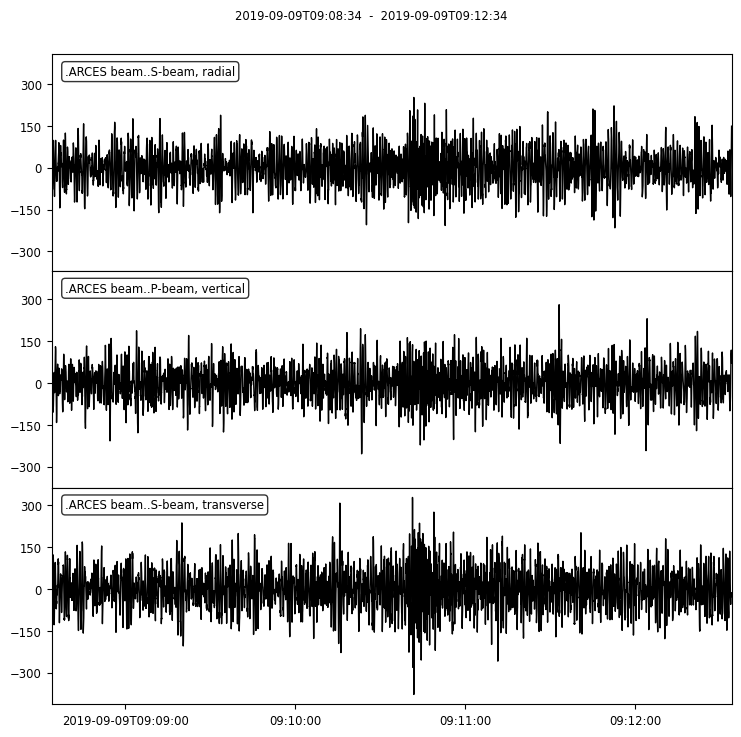

{   'analyst_pick_time': None,
    'baz_to_arces': 2.702789417290362,
    'est_arrivaltime_arces': '2019-09-09 09:09:34',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2019-09-09T09:08:34.000000Z',
                       'station': 'ARCES beam'}}


In [34]:
# Plotting false negative
index = false_positives_indexes[j]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(j)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
j += 1

# True Negatives

In [ ]:
k = 0

In [ ]:
# Plotting false negative
index = true_negative_indexes[k]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
k += 1

# False Negatives

In [2]:
m = 0

In [3]:
# Plotting false negative
index = false_negatives_indexes[m]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(m)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
m += 1

NameError: name 'false_negatives_indexes' is not defined